In [16]:
!pip install git+https://github.com/pytorch/tnt.git@master

  Cloning https://github.com/pytorch/tnt.git (to master) to /tmp/pip-mulpf3lk-build
    100% |################################| 92kB 3.3MB/s ta 0:00:011
    100% |################################| 133kB 3.0MB/s ta 0:00:01
    100% |################################| 143kB 3.0MB/s ta 0:00:01
    100% |################################| 337kB 2.3MB/s ta 0:00:01
    100% |################################| 61kB 3.8MB/s ta 0:00:011
  Running setup.py bdist_wheel for visdom ... done
  Stored in directory: /root/.cache/pip/wheels/ac/7f/50/2479ad6b7236ed7645cdf179af9ce68c82d3acff8fc81ba7fc
  Running setup.py bdist_wheel for torchfile ... done
  Stored in directory: /root/.cache/pip/wheels/27/0a/74/650124cbc320716ff2a6566e711a0c84f871647b33ffc868f6
Successfully built visdom torchfile
  Running setup.py install for torchnet ... done


In [1]:
# import lab_utils,
import torch, random
#from torchvision.datasets import CIFAR10 
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
from PIL import Image
import json, string
import numpy as np
import time, os
from collections import Counter
import json


#from pytorch_utilities import validation_set_split
from pytorch_utilities.plotting import pytorch_model_results

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
%matplotlib inline

In [2]:
# Verify GPU visibility
!nvidia-smi

Wed Nov 29 00:25:02 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:0A:00.0     Off |                  N/A |
| 41%   66C    P2    55W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
def pytorch_model_results(training_values, validation_values, metric='accuracy'):

    # Plot of the loss for training and validation after every epoch
    # --------------------------------------------------------------
    
    if metric == 'accuracy':
        plot_title = 'Training and validation accuracy values after each epoch'
        plot_ylabel = 'Avg Accuracy'
    elif metric == 'loss':
        plot_title = 'Training and validation loss values after each epoch'
        plot_ylabel = 'Avg Loss'

    plt.figure(figsize=(8, 6))

    # training loss
    x = [i+1 for i in range(0, len(training_values)) ]
    y = training_values
    training_plot = 'b^--'
    plt.plot(x, y, training_plot)

    # validation loss
    y = validation_values
    validation_plot = 'r.--'
    plt.plot(x, y, validation_plot)

    # legend, and labels
    plt.legend(['Training','Validation'])
    plt.title(plot_title)
    plt.xlabel('Epoch count')
    plt.ylabel(plot_ylabel)
    plt.xticks(x)

    plt.show()

In [4]:
# Define train_model() with scheduler and
# include loss and accuracy capture after each epoch.
# ---------------------------------------------------

from torch.optim import lr_scheduler

def train_model(network, criterion, optimizer, trainLoader, valLoader, scheduler,lr_step=False, n_epochs=20, use_gpu=True):
    
    training_accuracy_values = []
    validation_accuracy_values = []
    
    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            # Added
            # -----
            #if use_gpu:
                #loss = loss.cuda()

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        
        accuracy = 100 * correct / counter
        training_accuracy_values.append(accuracy)
        training_loss_values.append(cum_loss / (1 + i))
        
        # Make a pass over the validation data.
        # -------------------------------------
        
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        accuracy = 100 * correct / counter
        validation_accuracy_values.append(accuracy)
        validation_loss_values.append(cum_loss / (1 + i))
        
        # Scheduler
        # ---------
        if lr_step:
            scheduler.step()
        
    value_lists = [training_accuracy_values,validation_accuracy_values,training_loss_values,validation_loss_values]
    return value_lists

In [5]:
# https://stackoverflow.com/questions/43441673/trying-to-load-a-custom-dataset-in-pytorch

# Using ResNet 18.
# Note: I'm not going to freeze the weights
# since our dataset n > 1000
# -----------------------------------------

# resnet = models.resnet18(pretrained = True)
resnet = models.resnet50(pretrained = True)

### Load training and validation

To create a seperate validation set I used the following bash code:

`
find . -type f -exec dirname {} + | uniq -c | while read n d;do echo "Directory:$d Files:$n Moving random:$(($n / 10))";mkdir -p ../maindir2${d:1};find $d -type f | shuf -n $(($n / 10)) | while read file;do mv $file ../maindir2${d:1}/;done;done
`

I confirmed this successfully did not create duplicates using:

`diff -srq ./trainset/ ./valset/ | grep identical`

In [6]:
# Spectrogram dataset "v1" - 90% training 10% validation
# train_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_90tr10va/trainset/"
# val_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_90tr10va/valset/"

# Spectrogram dataset "v2" - 80% training 10% validation 10% testing (871 taken from training)
train_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/trainset/"
val_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/valset/"
test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/testset/"

# Original shape is 440x600
transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_set = dset.ImageFolder(train_path,transform=transform)
val_set = dset.ImageFolder(val_path,transform=transform)
test_set = dset.ImageFolder(test_path,transform=transform)

# This didn't work. Only selected one class. Ended up using a bash script to function as trainsetsplit
# train_set, val_set = validation_set_split.validation_split(dataset)


batch_size = 128
batch_size = 16

trainLoader = torch.utils.data.DataLoader(train_set, 
                                          batch_size = batch_size, 
                                          shuffle = True, 
                                          num_workers = 0
                                         )
valLoader = torch.utils.data.DataLoader(val_set, 
                                        batch_size = batch_size, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )
testLoader = torch.utils.data.DataLoader(test_set, 
                                        batch_size = batch_size, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )

In [7]:
class_dict = trainLoader.dataset.class_to_idx
class_dict = {v: k for k, v in class_dict.items()} # reverse key-value mappings

In [8]:
class_dict

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jack_hammer',
 8: 'siren',
 9: 'street_music'}

In [9]:
print(len(trainLoader.dataset))
print(len(valLoader.dataset))
print(len(testLoader.dataset))

6988
873
871


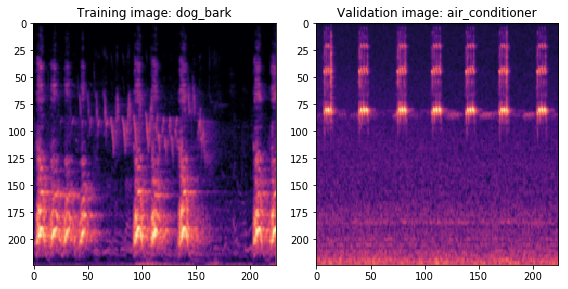

In [51]:
plt.figure(figsize=(8, 4))

sample_tensor, sample_class = trainLoader.dataset[2123]
sample_class = class_dict[sample_class]
sample_arr = sample_tensor.numpy()
sample_arr = np.rollaxis(sample_arr,0,3)
plt.subplot(1,2,1)
plt.imshow(sample_arr, interpolation='nearest')
plt.title(' '.join(["Training image:",sample_class]))

sample_tensor, sample_class = valLoader.dataset[5]
sample_class = class_dict[sample_class]
sample_arr = sample_tensor.numpy()
sample_arr = np.rollaxis(sample_arr,0,3)
plt.subplot(1,2,2)
plt.imshow(sample_arr, interpolation='nearest')
plt.title(' '.join(["Validation image:",sample_class]))

plt.tight_layout()

In [52]:
val_class_list = [valLoader.dataset[idx][1] for idx in range(0, len(valLoader.dataset))]
train_class_list = [trainLoader.dataset[idx][1] for idx in range(0, len(trainLoader.dataset))]
test_class_list = [testLoader.dataset[idx][1] for idx in range(0, len(testLoader.dataset))]

In [53]:
# Sanity check on class distributions
print(Counter(val_class_list))
print(Counter(train_class_list))
print(Counter(test_class_list))

Counter({0: 100, 2: 100, 3: 100, 4: 100, 5: 100, 7: 100, 9: 100, 8: 93, 1: 43, 6: 37})
Counter({0: 800, 2: 800, 3: 800, 4: 800, 5: 800, 7: 800, 9: 800, 8: 744, 1: 344, 6: 300})
Counter({0: 100, 2: 100, 3: 100, 4: 100, 5: 100, 7: 100, 9: 100, 8: 92, 1: 42, 6: 37})


Could be worth removing classes 1 and 6 (car_horn, gun_shot, and siren respectively) since the remaining classes have the same number of observations (minus 8 - siren, which is pretty close).

### Customize ResNet

In [10]:
# OPTIONAL #1: Replace FC layer so 
# model only predicts two variables
# ---------------------------------

print(resnet.fc)
total_classes = len(class_dict.keys())
resnet.fc = nn.Linear(resnet.fc.in_features, total_classes) # Our dataset has 2 classes
print(resnet.fc)

Linear (2048 -> 1000)
Linear (2048 -> 10)


### Train

In [11]:
import time

t0 = time.time()

# ------------------------------------------------------
# Retrain resnet on our dataset
# ------------------------------------------------------


criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(resnet.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0005)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Concerned that the momentum is too high for this because the validation is oscillating quite a bit
# Going to lower the learning rate
lr = 0.001
momentum = 0.9
weight_decay = 0.0005
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
exp_lr_scheduler = None

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)

n_epochs = 15
training_values = train_model(resnet, criterion, optimizer, trainLoader, valLoader, exp_lr_scheduler,lr_step=False, n_epochs = n_epochs, use_gpu=True)

# ------------------------------------------------------
# Time
# ------------------------------------------------------

t1 = time.time()
total = t1-t0

Validation epoch 14: 100%|██████████| 55/55 [00:06<00:00,  8.46it/s, accuracy=96.8, loss=0.125] 


In [12]:
print(total/60)

22.432915516694386


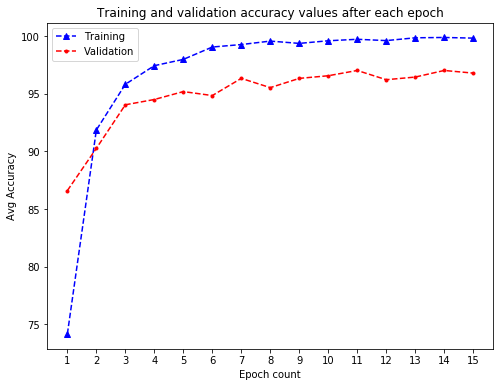

In [13]:
pytorch_model_results(training_values[0],training_values[1],metric='accuracy')

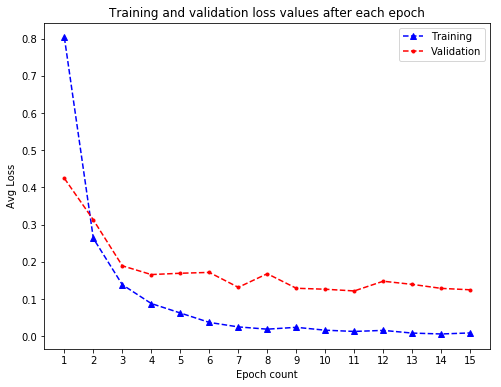

In [14]:
pytorch_model_results(training_values[2],training_values[3],metric='loss')

### Test

In [33]:
import torchnet.meter as meter

resnet.eval()
confusion_matrix = meter.ConfusionMeter(total_classes)
for ii, data in enumerate(testLoader):
    input, label = data
    val_input = Variable(input, volatile=True).cuda()
    val_label = Variable(label.type(torch.LongTensor), volatile=True).cuda()
    score = resnet(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
print(confusion_matrix.conf)

[[99  0  0  0  0  0  0  1  0  0]
 [ 0 41  0  0  0  0  0  0  0  1]
 [ 2  0 95  0  0  0  0  0  0  3]
 [ 1  0  4 90  0  0  0  0  1  4]
 [ 0  0  0  0 93  0  1  6  0  0]
 [ 1  0  1  1  1 96  0  0  0  0]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  1  1  0 97  0  1]
 [ 0  0  0  0  0  1  0  0 91  0]
 [ 1  0  0  0  0  0  0  1  0 98]]


In [50]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

In [83]:
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, classes, cmap,
                          normalize=False,
                          title='Confusion matrix',
                          font_family='Sans',
                          font_properties=[22,12,13,16,40,20]
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    title_font_size = font_properties[0]
    cell_font_size = font_properties[1]
    tick_font_size = font_properties[2]
    label_font_size = font_properties[3]
    cbar_font_size = font_properties[3]
    x_rotation = font_properties[4]
    cbar_pad = font_properties[5]
    family = font_family
    ha = 'right'
    
    if normalize:
        cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm_n.max() / 2.
    else:
        thresh = cm.max() / 2.
    
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(1, 1, 1,  aspect='equal')
    
    if normalize:
        plt.imshow(cm_n, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        
    plt.title(title, size=title_font_size, family=family)
    
    # Main plot
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=x_rotation, size=tick_font_size, family=family,  ha=ha)
    plt.yticks(tick_marks, classes, size=tick_font_size, family=family)

    if normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     size=cell_font_size,
                     color="white" if cm_n[i, j] > thresh else "black", 
                     family=family
                    )
    else:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     size=cell_font_size,
                     color="white" if cm[i, j] > thresh else "black",
                     family=family
                    )   

    plt.ylabel('True Label', size=label_font_size, family=family)
    plt.xlabel('Predicted Label', size=label_font_size, family=family)
    
    # Colorbar legend
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = cbar_pad
    #cbar.ax.tick_params(family=family)
    cbar.set_label('Class Sample Proportion', rotation=270, size=cbar_font_size, family=family)
    

    
    #plt.tight_layout()

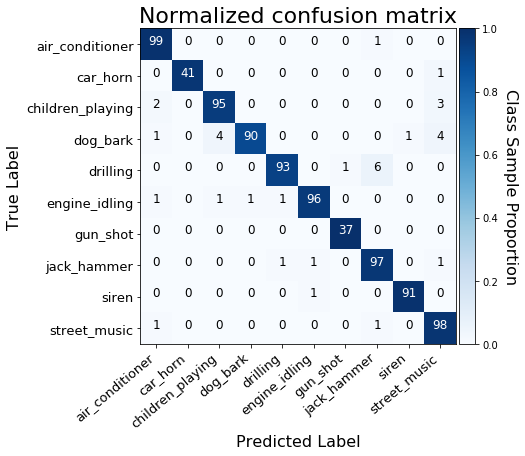

In [86]:
# Plot normalized confusion matrix
class_names = list(class_dict.values())

plot_confusion_matrix(confusion_matrix.conf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', cmap='Blues')

### Save model

In [15]:
# Save model parameters
# ---------------------

# Naming convention:
# [model]_[dataset version]_[data type]_[epoch]_[final accuracy %]
name = 'resnet50_v2_melspect_15_968'
dir_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/saved_models/cvr_final_project/"
extension = '.pt'
PATH = ''.join([dir_path,name,extension])
torch.save(resnet.state_dict(), PATH)

# Save hyper parameters and results
# ---------------------------------

experiment_log = {
    'lr':lr,
    'momentum':momentum,
    'weight_decay':weight_decay,
    'n_epochs':n_epochs,
    'training_accuracy':training_values[0],
    'validation_accuracy':training_values[1],
    'training_loss':training_values[2],
    'validation_loss':training_values[3],
    'optimizer':str(type(optimizer)),
    'criterion':str(type(criterion)),
    'train_time':total/60
}

with open(''.join([dir_path,name,'.txt']), 'w') as file:
     file.write(json.dumps(experiment_log))

# Evaluate on live samples

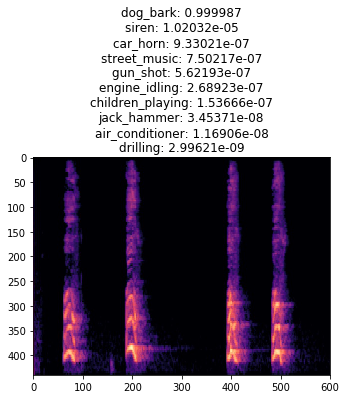

In [29]:
import torch.nn.functional as F
#imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image/testset/me_barking_171128.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

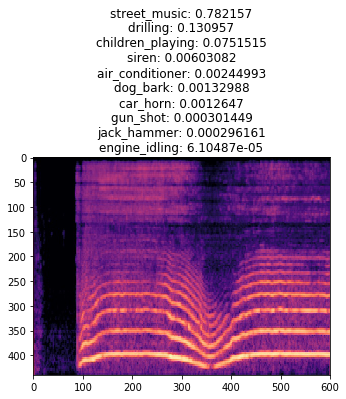

In [30]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image/testset/me_drilling-sound_171128.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

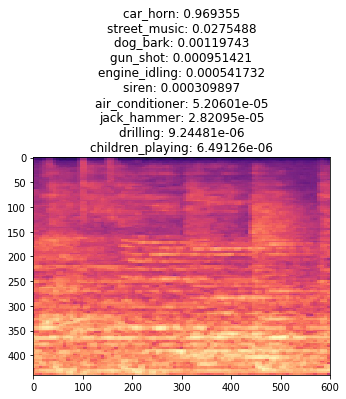

In [87]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/live_examples/171128_mudhouse_44100_1_001_music-noise-DURATION.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

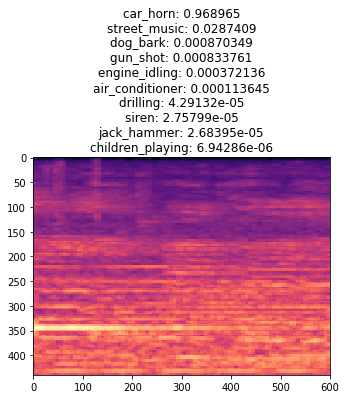

In [89]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/live_examples/171128_mudhouse_44100_1_002_music-noise-DURATION.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

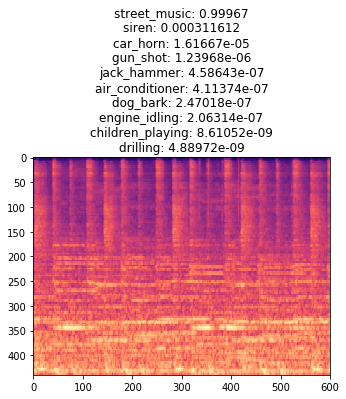

In [90]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/live_examples/171128_mudhouse_44100_4_002_music-noise-DURATION.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

In [120]:
# Using the feature extractor example provided by Vicente, with some slight modifications.
# ----------------------------------------------------------------------------------------
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.base_network = resnet.cuda() # need CUDA to use GPU
        #self.fc = 0
    
    # Additions
    #def classifier(self, feature_vector):
        #x = nn.Linear(feature_vectors.size()[0], n_classes)
        
    def forward(self, image):
        x = self.base_network.conv1(image)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)

        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)
        x = self.base_network.avgpool(x)
        features = x.view(x.size(0), -1)
        
        return features

In [121]:
# Build new training dataset from our ResNet feature extractor
# ------------------------------------------------------------

#torch.cuda.comm.broadcast
#torch.cuda.set_device(gpus[0])

label_list = []
FeatureExtractor().eval()
for i, data in enumerate(trainLoader, 0):
        
        # get the inputs
        inputs, label = data
        inputs = inputs.cuda()
        train_feature_set = FeatureExtractor().forward(Variable(inputs))
        
        if i > 0:
            tensor_stack = torch.cat((tensor_stack, train_feature_set.data))
        else:
            tensor_stack = train_feature_set.data.clone()
            
        label_list.append(label[0])

In [232]:
pd_target = tensor_stack.cpu().numpy() # need to move tensors to cpu to cast as numpy array
df = pd.DataFrame(pd_target
df['class'] = label_list

# save training dataset
#df.to_pickle('../data/dogs_cats_training.csv')

In [242]:
# Train our model using GBRT
# Note: GBRT train time is very slow,
# but run time is really fast. 
# -----------------------------------

from sklearn.ensemble import GradientBoostingClassifier as gbrt

x_train = df.drop('class',1)
y_train = df['class']

import time
start = time.time()

seed = 1234

# This is as simple test, so not using cross validation with validation sets from the training set to tune the model.
clf = gbrt(random_state = seed)

# clf = GradientBoostingClassifier(learning_rate = 0.03,
#                                  max_depth = 4, 
#                                  min_samples_leaf = 10,
#                                  max_features = 'sqrt',
#                                  n_estimators = 300,
#                                  min_samples_split = 50,
#                                  random_state = seed
#                                 )

clf = clf.fit(x_train,y_train)

end = time.time()-start
#plot_model_overview(clf,x_test,y_test.user_megatype)
print("Modeling time: %s" % end)

Modeling time: 490.08495688438416


In [243]:
## Save model
#from sklearn.externals import joblib
#joblib.dump(clf, '../data/gbrt.model')

['../data/gbrt.model']

In [248]:
# Define model overview plotting function since
# we don't have the loss and accuracy values like above
# -----------------------------------------------------

def plot_model_overview(model,x_in,y_in, digits=4):
    
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix

    predicted = model.predict(x_in)

    print('='*80)
    print(str(model))
    print('-'*80)

    print ('-'*21)
    print ("Classification Report")
    print ('-'*21)
    print(classification_report(y_in, predicted, digits=digits))
    print ('-'*32)
    print ("Confusion Matrix")
    print ('-'*32)
    print (confusion_matrix(y_in, predicted))

    from sklearn.metrics import accuracy_score
    print ('-'*25)
    print ("Accuracy Score")
    print ('-'*25)
    print (accuracy_score(y_in, predicted))

    from sklearn.metrics import f1_score
    print ('-'*25)
    print ("F1-Score")
    print ('-'*25)
    print (f1_score(y_in, predicted))
    print(' ')

In [249]:
# You should wrap this in a function or python script so that you can call it for something like TSNE+plot
label_list = []
FeatureExtractor().eval()
for i, data in enumerate(valLoader, 0):
        
        # get the inputs
        inputs, label = data
        inputs = inputs.cuda()
        feature_set = FeatureExtractor().forward(Variable(inputs))
        
        if i > 0:
            tensor_stack = torch.cat((tensor_stack, feature_set.data))
        else:
            tensor_stack = train_feature_set.data.clone()
            
        label_list.append(label[0])

In [250]:
pd_target = tensor_stack.cpu().numpy()
df = pd.DataFrame(pd_target)
df['class'] = label_list

# save training dataset
#df.to_pickle('../data/dogs_cats_validation.csv')

In [252]:
# NOTE: 0 corresponds to "Cat" and 1 corresponds to "Dog"
# Also note: Sklearn GBRT doesn't provide a convenient
# way to visualize the loss during training, so instead
# of providing the typical charts (like above), I will
# provide a model summary based on various metrics.
# -------------------------------------------------------

x_test = df.drop('class',1)
y_test = df['class']

# Test model on entire validation set
plot_model_overview(clf,x_test,y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)
--------------------------------------------------------------------------------
---------------------
Classification Report
---------------------
             precision    recall  f1-score   support

          0     0.9907    0.9804    0.9855      2500
          1     0.9806    0.9908    0.9857      2500

avg / total     0.9857    0.9856    0.9856      5000

--------------------------------
Confusion Matrix
--------------------------------
[[2451   49]
 [  23 2477]]
-------------------------
Accuracy Score
----------------

In [299]:
len(clf.estimators_)

100

Example of misclassification:
Predicted class: [1]
Actual class: 0


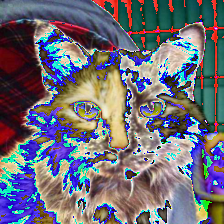

In [282]:
def tensor2pil(tensor):
    return transforms.ToPILImage()(tensor)

target = 0
print("Example of misclassification:")
print("Predicted class:", clf.predict(np.array(x_test.iloc[target,:]).reshape(1,-1)))
print("Actual class:", y_test[target])
tensor2pil(valLoader.dataset[target][0])

Example of correct classification:
Predicted class: [0]
Actual class: 0


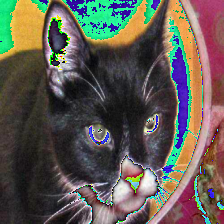

In [292]:
target = 1
print("Example of correct classification:")
print("Predicted class:", clf.predict(np.array(x_test.iloc[target,:]).reshape(1,-1)))
print("Actual class:", y_test[target])
tensor2pil(valLoader.dataset[target][0])

Example of correct classification:
Predicted class: [1]
Actual class: 1


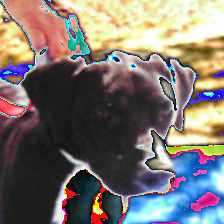

In [291]:
target = 2502

print("Example of correct classification:")
print("Predicted class:", clf.predict(np.array(x_test.iloc[target,:]).reshape(1,-1)))
print("Actual class:", y_test[target])
tensor2pil(valLoader.dataset[target][0])

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>